# Generate simulated data

Generate simulated data by sampling from VAE latent sapce

Workflow:
1. Input gene expression data from 1 experiment (here we are assuming that there is only biological variation within this experiment)
2. Encode this input into a latent space using the trained VAE model
3. For each encoded feature, sample from a distribution using the the mean and standard deviation for that feature
4. Decode the samples

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
import pickle
from keras.models import model_from_json, load_model
from ggplot import *
import umap
import warnings
warnings.filterwarnings(action='once')

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


In [2]:
# Parameters
analysis_name = 'full_dataset'
NN_architecture = 'NN_2500_300'
num_simulated_samples = 1000

In [3]:
# Create directories
new_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "simulated")

analysis_dir = os.path.join(new_dir, analysis_name)

if os.path.exists(analysis_dir):
    print('directory already exists: {}'.format(analysis_dir))
else:
    print('creating new directory: {}'.format(analysis_dir))
os.makedirs(analysis_dir, exist_ok=True)

directory already exists: /home/alexandra/Documents/Repos/Batch_effects_simulation/data/simulated/full_dataset


In [4]:
# Load arguments
normalized_data_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    "input",
    "train_set_normalized.pcl")

metadata_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    "metadata",
    "sample_annotations.tsv")

model_encoder_file = glob.glob(os.path.join(
    os.path.dirname(os.getcwd()),
    "models",
    NN_architecture,
    "*_encoder_model.h5"))[0]

weights_encoder_file = glob.glob(os.path.join(
    os.path.dirname(os.getcwd()),
    "models",
    NN_architecture,
    "*_encoder_weights.h5"))[0]

model_decoder_file = glob.glob(os.path.join(
    os.path.dirname(os.getcwd()),
    "models", 
    NN_architecture,
    "*_decoder_model.h5"))[0]


weights_decoder_file = glob.glob(os.path.join(
    os.path.dirname(os.getcwd()),
    "models",  
    NN_architecture,
    "*_decoder_weights.h5"))[0]

# Saved models
loaded_model = load_model(model_encoder_file)
loaded_decode_model = load_model(model_decoder_file)

loaded_model.load_weights(weights_encoder_file)
loaded_decode_model.load_weights(weights_decoder_file)

# Output
simulated_data_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    "simulated",
    analysis_name,
    "simulated_data.txt")

umap_model_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "models",  
    NN_architecture,
    "umap_model.pkl")

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
# Read data
normalized_data = pd.read_table(
    normalized_data_file,
    header=0,
    sep='\t',
    index_col=0).T

print(normalized_data.shape)
normalized_data.head(10)

(950, 5549)


Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814
control1aerobic_Pae_G1a.CEL,0.365512,0.572967,0.417762,0.663096,0.424846,0.606590,0.378900,0.224257,0.161582,0.074461,...,0.491161,0.565151,0.595824,0.382989,0.352268,0.250905,0.362161,0.487777,0.729434,0.483384
control1_anaerobic_Pae_G1a.CEL,0.689254,0.723461,0.510094,0.801569,0.619374,0.937262,0.138600,0.298615,0.306533,0.032482,...,0.754845,0.711126,0.589279,0.542699,0.591066,0.421389,0.392671,0.686055,0.911163,0.585208
control2aerobic_Pae_G1a.CEL,0.353000,0.580626,0.302544,0.639624,0.281793,0.687343,0.462645,0.000000,0.107961,0.093163,...,0.466139,0.545104,0.487957,0.330583,0.419139,0.328478,0.298493,0.254059,0.588305,0.406311
control2_anaerobic_Pae_G1a.CEL,0.674305,0.680740,0.515478,0.747121,0.656701,0.910654,0.149744,0.262492,0.263528,0.019910,...,0.775338,0.653142,0.642205,0.550935,0.565532,0.458622,0.426767,0.701314,0.886074,0.556363
control3aerobic_Pae_G1a.CEL,0.399186,0.653977,0.328755,0.692895,0.482482,0.618446,0.308135,0.191401,0.201170,0.020375,...,0.560889,0.654797,0.493961,0.454766,0.464733,0.456465,0.348577,0.503229,0.718768,0.474649


## Plot input data using UMAP

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/umap_.py:328: NumbaWarning: Function "fuzzy_simplicial_set" failed type inference: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/umap_.py", line 443:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/umap_.py:328: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.
  @numba.jit()
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 4 connected components using meta-embedding (experimental)
  n_components
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/n

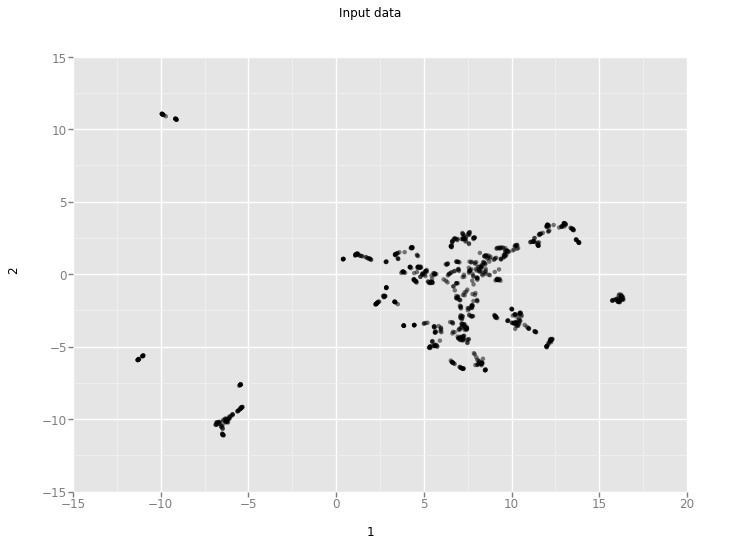

<ggplot: (-9223363286309975906)>


In [6]:
# UMAP embedding

# Get and save model
model = umap.UMAP(random_state=randomState).fit(normalized_data)
pickle.dump(model, open(umap_model_file, 'wb'))

input_data_UMAPencoded = model.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])


g = ggplot(aes(x='1',y='2'), data=input_data_UMAPencoded_df) + \
            geom_point(alpha=0.5) + \
            scale_color_brewer(type='qual', palette='Set2') + \
            scale_x_continuous(limits=(-15,20)) +\
            scale_y_continuous(limits=(-15,15)) + \
            ggtitle("Input data")

print(g)

## Simulate data

Generate new simulated data by sampling from the distribution of latent space features.  In other words, for each latent space feature get the mean and standard deviation.  Then we can generate a new sample by sampling from a distribution with this mean and standard deviation.

In [7]:
# Simulate data

# Encode into latent space
data_encoded = loaded_model.predict_on_batch(normalized_data)
data_encoded_df = pd.DataFrame(data_encoded, index=normalized_data.index)

latent_dim = data_encoded_df.shape[1]

# Get mean and standard deviation per encoded feature
encoded_means = data_encoded_df.mean(axis=0)

encoded_stds = data_encoded_df.std(axis=0)

# Generate samples 
new_data = np.zeros([num_simulated_samples,latent_dim])
for j in range(latent_dim):
    # Use mean and std for feature
    #new_data[:,j] = np.random.normal(encoded_means[j], encoded_stds[j], num_simulated_samples) 
    
    # Use standard normal
    new_data[:,j] = np.random.normal(0, 1, num_simulated_samples)
    
new_data_df = pd.DataFrame(data=new_data)

# Decode N samples
new_data_decoded = loaded_decode_model.predict_on_batch(new_data_df)
new_data_decoded_df = pd.DataFrame(data=new_data_decoded)

new_data_decoded_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548
0,0.703780,0.778287,0.238861,0.734408,0.273585,0.377228,0.373340,0.382202,0.352973,0.031605,...,0.141023,0.564054,0.613940,0.538738,0.582325,0.054016,0.415382,0.448256,0.775769,0.826781
1,0.746111,0.699440,0.432189,0.770400,0.354997,0.452408,0.115619,0.421320,0.512576,0.021851,...,0.353110,0.658591,0.679618,0.608793,0.878092,0.073905,0.493237,0.527566,0.899727,0.960000
2,0.889196,0.857507,0.204928,0.735466,0.239979,0.478234,0.120392,0.321480,0.542987,0.004515,...,0.114903,0.414167,0.726522,0.718479,0.673557,0.042760,0.439444,0.591535,0.906518,0.902557
3,0.706530,0.753610,0.498257,0.630696,0.429063,0.492487,0.244062,0.378496,0.371304,0.091834,...,0.555602,0.586244,0.593674,0.559532,0.459834,0.239749,0.515724,0.401679,0.784739,0.813834
4,0.620690,0.573908,0.459229,0.616093,0.394752,0.338957,0.266244,0.453393,0.680897,0.165412,...,0.337858,0.536912,0.609553,0.495774,0.494975,0.239664,0.523357,0.521566,0.755123,0.711477
5,0.621573,0.748386,0.378853,0.559681,0.269596,0.420197,0.289821,0.409316,0.397790,0.173150,...,0.404775,0.567309,0.625236,0.545770,0.461624,0.310117,0.474163,0.488520,0.707914,0.705264
6,0.674406,0.567372,0.425101,0.639968,0.500719,0.646400,0.241493,0.447431,0.537447,0.060158,...,0.410994,0.650453,0.669414,0.604272,0.863262,0.147942,0.661143,0.741634,0.890013,0.875748
7,0.579360,0.652389,0.431390,0.520049,0.519744,0.588891,0.395895,0.419499,0.495711,0.229298,...,0.362883,0.535504,0.586929,0.579140,0.648333,0.289062,0.536845,0.359980,0.674332,0.615210
8,0.627385,0.599111,0.310402,0.692201,0.303749,0.294114,0.272401,0.528678,0.468929,0.091113,...,0.311689,0.384363,0.499573,0.473442,0.480919,0.223983,0.470415,0.562502,0.690076,0.751135
9,0.793267,0.701303,0.348043,0.702794,0.344895,0.261903,0.118446,0.518176,0.540545,0.044017,...,0.311156,0.616932,0.553576,0.528964,0.746548,0.152435,0.503052,0.338930,0.771375,0.772830


## Plot encoded input data using UMAP

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


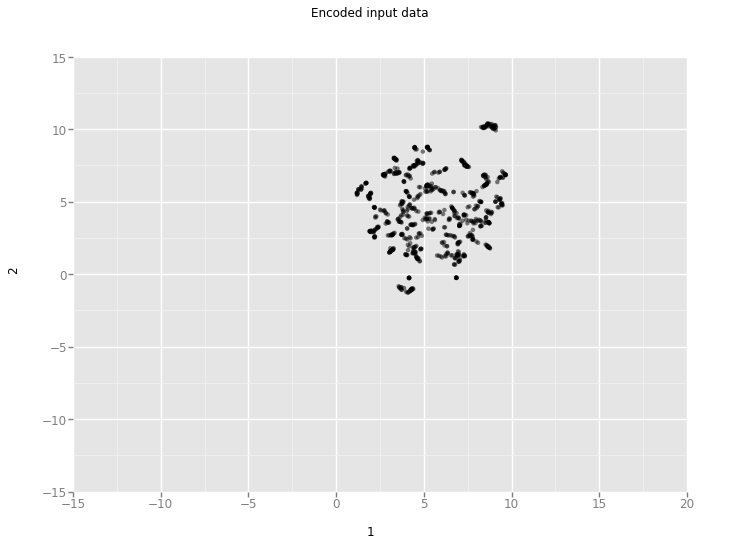

<ggplot: (-9223363286260785941)>


In [8]:
latent_data_UMAPencoded = umap.UMAP(random_state=randomState).fit_transform(data_encoded_df)
latent_data_UMAPencoded_df = pd.DataFrame(data=latent_data_UMAPencoded,
                                         index=data_encoded_df.index,
                                         columns=['1','2'])


g = ggplot(aes(x='1',y='2'), data=latent_data_UMAPencoded_df) + \
            geom_point(alpha=0.5) + \
            scale_color_brewer(type='qual', palette='Set2') + \
            scale_x_continuous(limits=(-15,20)) +\
            scale_y_continuous(limits=(-15,15)) + \
            ggtitle("Encoded input data")

print(g)

## Plot simulated data using UMAP

Note: we will use the same UMAP mapping for the input and simulated data to ensure they are plotted on the same space.

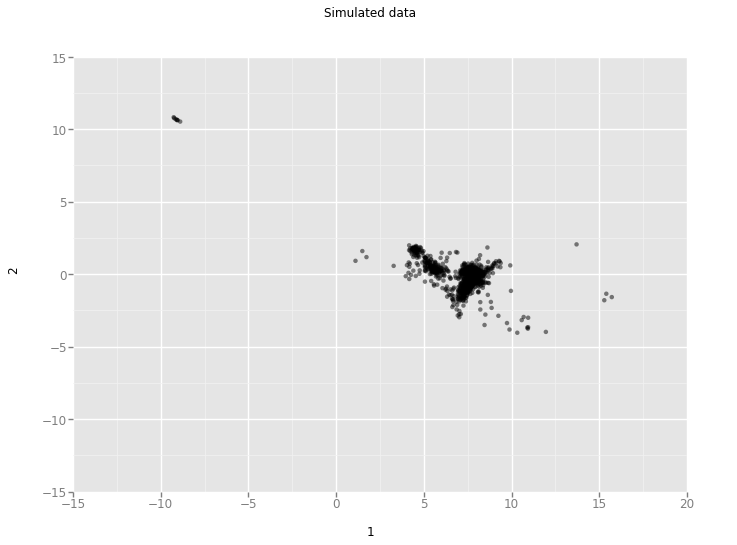

<ggplot: (-9223363286308254748)>


In [9]:
# UMAP embedding
simulated_data_UMAPencoded = model.transform(new_data_decoded_df)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=new_data_decoded_df.index,
                                         columns=['1','2'])


g = ggplot(aes(x='1',y='2'), data=simulated_data_UMAPencoded_df) + \
            geom_point(alpha=0.5) + \
            scale_color_brewer(type='qual', palette='Set2') + \
            scale_x_continuous(limits=(-15,20)) +\
            scale_y_continuous(limits=(-15,15)) + \
            ggtitle("Simulated data")

print(g)

In [10]:
# Output
#new_data_decoded_df.to_csv(simulated_data_file, sep='\t')